# Naive Risk Budgeting Strategies between PSP and GHP

In [1]:
import numpy as np
import pandas as pd
import risk_ as rk
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def bt_mix(r1, r2, allocator, **kwargs):
    """
    Runs a back test (simulation) of allocating between a two sets of returns
    r1 and r2 are T x N DataFrames or returns where T is the time step index and N is the number of scenarios.
    allocator is a function that takes two sets of returns and allocator specific parameters, and produces
    an allocation to the first portfolio (the rest of the money is invested in the GHP) as a T x 1 DataFrame
    Returns a T x N DataFrame of the resulting N portfolio scenarios
    """
    if not r1.shape == r2.shape:
        raise ValueError("r1 and r2 should have the same shape")
    weights = allocator(r1, r2, **kwargs)
    if not weights.shape == r1.shape:
        raise ValueError("Allocator returned weights with a different shape than the returns")
    r_mix = weights*r1 + (1-weights)*r2
    return r_mix

In [3]:
def fixedmix_allocator(r1, r2, w1, **kwargs):
    """
    Produces a time series over T steps of allocations between the PSP and GHP across N scenarios
    PSP and GHP are T x N DataFrames that represent the returns of the PSP and GHP such that:
     each column is a scenario
     each row is the price for a timestep
    Returns an T x N DataFrame of PSP Weights
    """
    return pd.DataFrame(data = w1, index=r1.index, columns=r1.columns)

In [4]:
rates, zc_prices = rk.cir(10, 500, b=0.03, r_0 = 0.03)
price_10 = rk.bond_price(10, 100, .05, 12, rates)
price_30 = rk.bond_price(30, 100, .05, 12, rates)
rets_30 = rk.bond_total_return(price_30, 100, .05, 12)
rets_10 = rk.bond_total_return(price_10, 100, .05, 12)
rets_bonds = rk.bt_mix(rets_10, rets_30, allocator=rk.fixedmix_allocator, w1=.6)
mean_rets_bonds = rets_bonds.mean(axis='columns')
rk.summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.036443,0.003603,0.566742,3.482168,-0.001467,-0.00121,1.740295,0.0


In [8]:
price_eq = rk.gbm(n_years=10, n_scenarios=500, mu=0.07, sigma=0.15)
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()

In [11]:
rets_7030b = rk.bt_mix(rets_eq, rets_bonds, allocator=rk.fixedmix_allocator, w1=0.7)
rets_7030b_mean = rets_7030b.mean(axis=1)
rk.summary_stats(pd.DataFrame(rets_7030b_mean))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.062341,0.004193,-0.424361,3.281696,-0.002936,-0.002193,7.507663,0.0


In [12]:
summaries = rk.summary_stats(rets_7030b)

In [13]:
summaries.head()

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.098203,0.103429,0.370107,3.697548,0.037010,0.048458,0.641709,-0.099964
1,0.098618,0.104353,0.026742,3.584786,0.040445,0.056387,0.639894,-0.298211
2,0.062181,0.106521,-0.375762,3.287652,0.047870,0.065161,0.293911,-0.271821
3,0.015019,0.098779,0.059528,2.692287,0.044756,0.051921,-0.147719,-0.165250
4,0.058064,0.115821,-0.248770,2.633179,0.052058,0.066921,0.235691,-0.223267


In [15]:
summaries.mean()

Annualized Return          0.056873
Annualized Vol             0.106996
Skewness                  -0.003334
Kurtosis                   2.974251
Cornish-Fisher VaR (5%)    0.045556
Historic CVaR (5%)         0.057769
Sharpe Ratio               0.245719
Max Drawdown              -0.203488
dtype: float64

In [17]:
def terminal_values(rets):
    """
    Returns the final values of a dollar at the end of the period for each period
    """
    return (rets+1).prod()

In [19]:
pd.concat([
    rk.terminal_stats(rets_bonds, name="FI"),
    rk.terminal_stats(rets_eq, name="Equities"),
    rk.terminal_stats(rets_7030b, name="70/30")
], axis=1)

,FI,Equities,70/30
mean,1.392530,2.024315,1.822660
std,0.108785,0.979092,0.605346
p_breach,NaN,0.040000,0.004000
e_short,NaN,0.102372,0.130340
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


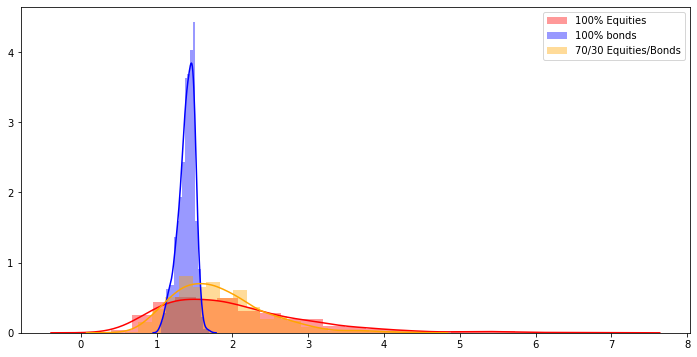

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
sns.distplot(rk.terminal_values(rets_eq), color="red", label="100% Equities")
sns.distplot(rk.terminal_values(rets_bonds), color="blue", label="100% bonds")
sns.distplot(rk.terminal_values(rets_7030b), color="orange", label="70/30 Equities/Bonds")
plt.legend();

# Glide Paths for Allocation

In [24]:
def glidepath_allocator(r1, r2, start_glide=1, end_glide=0):
    """
    Simulates a Target-Date-Fund style gradual move from r1 to r2
    """
    n_points = r1.shape[0]
    n_col = r1.shape[1]
    path = pd.Series(data=np.linespace(start_glide, end_glide, num=n_points))
    paths = pd.concat([path]*n_col, axis=1)
    paths.index = r1.index
    paths.columns = r1.columns
    return paths

In [31]:
# Next step is to build better allocators to compare portfolios
rets_g8020 = rk.bt_mix(rets_eq, rets_bonds, allocator=rk.glidepath_allocator, start_glide=.80, end_glide=.20)
pd.concat([
    rk.terminal_stats(rets_eq, name="Equities"),
    rk.terminal_stats(rets_bonds, name="Bonds"),
    rk.terminal_stats(rets_g8020, name="Glide 80 to 20"),
    rk.terminal_stats(rets_7030b, name="70/30")
], axis=1)

,Equities,Bonds,Glide 80 to 20,70/30
mean,2.024315,1.392530,1.688909,1.822660
std,0.979092,0.108785,0.438177,0.605346
p_breach,0.040000,NaN,0.004000,0.004000
e_short,0.102372,NaN,0.049660,0.130340
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN
